In [1]:
import openmm
import openmm.app
import numpy as np
import torch
import mdtraj as md
import ot
import os
import MDAnalysis
import matplotlib.pyplot as plt
from bgflow import MeanFreeNormalDistribution, OpenMMBridge, OpenMMEnergy
from bgflow.utils import distance_vectors, as_numpy
import sys
sys.path.append('../')
sys.path.append('../BoltzNCE/')
from infer_aa2 import fix_chirality
from bgflow.utils import remove_mean, as_numpy
from bgflow import MeanFreeNormalDistribution, OpenMMBridge, OpenMMEnergy
from bgflow.bg import sampling_efficiency
sys.path.append('../')
from BoltzNCE.utils.tbg_utils import create_adjacency_list, find_chirality_centers, compute_chirality_sign, check_symmetry_change
import tqdm
import os
import mdtraj as md
import networkx as nx
from networkx.algorithms import isomorphism
from infer_aa2 import phi_to_grid, run_tica, tica_features,plot_tic01
from infer_aa2 import plot_fes

/net/galaxy/home/koes/rishal/.conda/envs/BoltzNCE/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with 

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
#test_dipeptides=['AC','ET','GN','IM','KS','NY','NF']
test_dipeptide='AC'

In [4]:
def calc_energy_w2(gen_energies, holdout_energies,prefix=''):
    """Calcualate and log energy and torsion w2 distance 

    Args:
        gen_energies (np list): tensor of generated samples energies
        holdout_energies (np list): tenosr of holdout sample energies, must be same shape and size as gen samples
    """
    
    
    
    # flatten both to 1-D
    
    gen_energies = gen_energies.ravel()
    holdout_energies = holdout_energies.ravel()

    # sort them
    # gen_energies_sorted = np.sort(gen_energies)
    # holdout_energies_sorted = np.sort(holdout_energies)
    loss = ot.emd2_1d(gen_energies,holdout_energies,metric = "sqeuclidean")

    # # compute MSE of the sorted values = W2^2
    # w2_squared = np.mean((gen_energies_sorted - holdout_energies_sorted)**2)

    # # take sqrt to get W2
    # W2 = np.sqrt(w2_squared)
    
    # if you want to log to wandb (scalar)
    return np.sqrt(loss)

def calc_torsion_w2(gen_angles,holdout_angles, prefix=''):
    """calculates OT w2 Torsion angles 

    Args:
        gen_angles (np list ): np array of sidechain angles 
        holdout_angles (_type_): np array of sidechain angles
    """
    dist = np.expand_dims(gen_angles,0) - np.expand_dims(holdout_angles,1)
    dist = np.sum((dist % np.pi)**2,axis = -1)
    # dist = np.sqrt(dist)
    a, b = ot.unif(gen_angles.shape[0]), ot.unif(gen_angles.shape[0])
    W,log = ot.emd2(a,b,dist,log = True, numItermax=1e9) # uniform weights as input
    # w2_circle = ot.wasserstein_circle(gen_angles, holdout_angles, p=2)
    W = np.sqrt(W)
    # print(f"Angles W2 distance: {w2_circle}")
    
    # w2_circle = ot.wasserstein_circle(gen_angles, holdout_angles, p=2)
    return W

In [5]:
def calculate_w2_distances(phis,psis,phis_data,psis_data,log_w_np,energies,energies_data,prefix=''):

    energies_w2_proposal_list = []
    angles_w2_proposal_list = []
    energies_w2_reweighted_list = []
    angles_w2_reweighted_list = []
    for i in range(1):
        #subsample 10000 samples from data
        if len(phis_data)>10000:
            idxs = np.random.choice(len(phis_data), 10000, replace=False)
            phis_gt = phis_data[idxs]
            psis_gt = psis_data[idxs]
            angles_gt = np.concatenate([phis_gt[:, None], psis_gt[:, None]], axis=-1)
        if len(energies_data)>10000:
            idxs = np.random.choice(len(energies_data), 10000, replace=False)    
            energies_gt = energies_data[idxs]
        
        if len(phis)>10000:
            idxs = np.random.choice(len(phis), 10000, replace=False)
            phis_proposal = phis[idxs]
            psis_proposal = psis[idxs]
            angles_proposal = np.concatenate([phis_proposal[:, None], psis_proposal[:, None]], axis=-1)
        if len(energies)>10000:
            idxs = np.random.choice(len(energies), 10000, replace=False)
            energies_proposal = energies[idxs]


        #subsample 10000 samples from with log_w_np weights
        if len(phis)>10000:
            idxs = np.random.choice(len(phis), 10000, replace=True, p=np.exp(log_w_np[:,0])/np.sum(np.exp(log_w_np[:,0])))
            phis_reweighted = phis[idxs]
            psis_reweighted = psis[idxs]
            angles_reweighted = np.concatenate([phis_reweighted[:, None], psis_reweighted[:, None]], axis=-1)
        if len(energies)>10000:
            idxs = np.random.choice(len(energies), 10000, replace=True, p=np.exp(log_w_np[:,0])/np.sum(np.exp(log_w_np[:,0])))
            energies_reweighted = energies[idxs]
        energy_w2 = calc_energy_w2(energies_proposal, energies_gt,prefix=prefix)
        energies_w2_proposal_list.append(energy_w2)
        angles_w2= calc_torsion_w2(angles_proposal, angles_gt,prefix=prefix)
        angles_w2_proposal_list.append(angles_w2)
        energy_w2_reweighted = calc_energy_w2(energies_reweighted, energies_gt,prefix=prefix)
        energies_w2_reweighted_list.append(energy_w2_reweighted)
        angles_w2_reweighted = calc_torsion_w2(angles_reweighted, angles_gt,prefix=prefix)
        angles_w2_reweighted_list.append(angles_w2_reweighted)
    energies_w2_proposal_mean = np.mean(energies_w2_proposal_list)
    angles_w2_proposal_mean = np.mean(angles_w2_proposal_list)
    energies_w2_proposal_std = np.std(energies_w2_proposal_list)
    angles_w2_proposal_std = np.std(angles_w2_proposal_list)
    energies_w2_reweighted_mean = np.mean(energies_w2_reweighted_list)
    angles_w2_reweighted_mean = np.mean(angles_w2_reweighted_list)
    print(prefix + "Energies W2 distance proposal mean:", energies_w2_proposal_mean)
    print(prefix + "Energies W2 distance proposal std:", energies_w2_proposal_std)
    print(prefix + "Angles W2 distance proposal mean:", angles_w2_proposal_mean)
    print(prefix + "Angles W2 distance proposal std:", angles_w2_proposal_std)
    print(prefix + "Energies W2 distance reweighted mean:", energies_w2_reweighted_mean)
    print(prefix + "Angles W2 distance reweighted mean:", angles_w2_reweighted_mean)
    print(prefix + "Energies W2 distance reweighted std:", np.std(energies_w2_reweighted_list))
    print(prefix + "Angles W2 distance reweighted std:", np.std(angles_w2_reweighted_list))
    return energies_w2_proposal_mean, angles_w2_proposal_mean,energies_w2_reweighted_mean,angles_w2_reweighted_mean

In [6]:
def compute_free_energy_difference(phis, log_w_np, prefix=''):
    left = 0.
    right = 2

    hist, edges = np.histogram(phis, bins=100, density=True,weights=np.exp(log_w_np[:,0]))
    centers = 0.5*(edges[1:] + edges[:-1])
    centers_pos = (centers > left) & (centers < right)
    
    free_energy_difference = -np.log(hist[centers_pos].sum()/
    hist[~centers_pos].sum())
    print(prefix + " Free energy difference:", free_energy_difference)
    return free_energy_difference

In [7]:
pdb_path=f'../data/2AA-1-huge/test/{test_dipeptide}-traj-state0.pdb'
topology = md.load(pdb_path).topology
test_md_xyz = np.load(f'../data/2AA-1-huge/test/{test_dipeptide}-traj-arrays.npz')
test_md=md.Trajectory(test_md_xyz['positions'], topology=topology)
pred_md = np.load(f'../generated/{test_dipeptide}_ebm_100k_{test_dipeptide}_potential_samples_dict_epoch_31_threshold_0.2.npz')
#pred_md=np.load(f'../generated/tbg_full_biased_{test_dipeptide}.npz')
try:
    pred_md_xyz = pred_md['samples']
    pred_md_energies = pred_md['energies']
    pred_md_weights = pred_md['log_w']
except:
    pred_md_xyz = pred_md['samples_np']
    pred_md_energies = pred_md['latent_np']
    pred_md_weights = pred_md['dlogp_np']

In [8]:
print(f"Test MD shape: {test_md_xyz['positions'].shape}")
print(f"Pred MD shape: {pred_md_xyz.shape}")
print(f"pred_md_energies shape: {pred_md_energies.shape}")
print(f"pred_md_weights shape: {pred_md_weights.shape}")
pred_md_xyz = pred_md_xyz[:pred_md_energies.shape[0]]
print(f"pred_md_xyz shape: {pred_md_xyz.shape}")

Test MD shape: (200000, 24, 3)
Pred MD shape: (89376, 24, 3)
pred_md_energies shape: (89198, 1)
pred_md_weights shape: (89198, 1)
pred_md_xyz shape: (89198, 24, 3)


In [9]:
test_xyz = test_md.xyz[test_md_xyz['step'] % 10000 == 0][:190000]
pred_md_xyz=pred_md_xyz.reshape(-1,test_xyz.shape[1],3)
pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)


In [10]:
pdb = openmm.app.PDBFile(pdb_path)
forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")

system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
        nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))
classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(test_xyz)[::10].reshape(-1, test_xyz.shape[-1]*test_xyz.shape[-2])))

In [11]:
print(pred_md_weights.shape)

(89198, 1)


In [22]:
def plot_energies(classical_target_energies, pred_md_energies, pred_md_weights,save_path=''):
    plt.figure(figsize=(16, 9))
    range_limits = (classical_target_energies.min()-10,classical_target_energies.max()+100)
    plt.hist(classical_target_energies, bins=100, alpha=0.5,density=True,range=range_limits, label='MD Simulation')
    plt.hist(pred_md_energies, bins=100, alpha=0.5,density=True,range=range_limits, label='Boltzmann Emulator')
    plt.hist(pred_md_energies, bins=100, alpha=0.5,density=True,range=range_limits,weights=np.exp(pred_md_weights),histtype='step', linewidth=5,label='BoltzNCE Reweighted')
    plt.legend(fontsize=35)
    plt.ylabel("KDE", fontsize=55)
    plt.xlabel("Energy  / $k_B T$", fontsize=55)  
    plt.yticks(fontsize=35)
    plt.xticks(fontsize=35)
    plt.legend(fontsize=35)
    plt.title("Energy Distribution", fontsize=55)
    if save_path != '':
        plt.savefig(save_path,bbox_inches='tight', dpi=300, format='pdf')
    else:
        plt.show()
    plt.close()

    

In [13]:
plot_energies(classical_target_energies, pred_md_energies, pred_md_weights,save_path=f'{test_dipeptide}_energy_distribution.pdf')

In [13]:
phis_traj=md.compute_phi(pred_md_traj)[1].flatten()
phis_test=md.compute_phi(test_md)[1].flatten()
fed_traj=compute_free_energy_difference(phis_traj, pred_md_weights, prefix='Trajectory')
fed_test=compute_free_energy_difference(phis_test, np.zeros((phis_test.shape[0],1)), prefix='Test')
estimation_error=np.abs(fed_traj-fed_test)
print("Estimation error:", estimation_error)

Trajectory Free energy difference: 3.301312120114939
Test Free energy difference: 3.6647931810937897
Estimation error: 0.3634810609788506


In [14]:
psis_traj=md.compute_psi(pred_md_traj)[1].flatten()
psis_test=md.compute_psi(test_md)[1].flatten()

In [15]:
def plot_fes_phis(phis_test,phis_traj,pred_md_weights,save_path=''):
    grid_left_data, fes_left_data, grid_right_data, fes_right_data = phi_to_grid(phis_test.flatten())
    grid_left, fes_left, grid_right, fes_right = phi_to_grid(phis_traj.flatten())
    grid_left_weighted, fes_left_weighted, grid_right_weighted, fes_right_weighted = phi_to_grid(phis_traj.flatten(), weights=np.exp(pred_md_weights))
    plt.figure(figsize=(16,9))
    plt.plot(np.hstack([grid_left_data, grid_right_data]), np.hstack([fes_left_data, fes_right_data]), linewidth=5, label="MD")
    plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="Boltzmann Emulator")
    plt.plot(np.hstack([grid_left_weighted, grid_right_weighted]), np.hstack([fes_left_weighted, fes_right_weighted]), linewidth=5, linestyle="--", label="BoltzNCE Reweighted")
    plt.legend(fontsize=35)
    plt.title(r"Free energy projection $\varphi$", fontsize=55)
    plt.xlabel(r"$\varphi$", fontsize=55)
    plt.ylabel("Free energy / $k_B T$", fontsize=55)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    if save_path != '':
        plt.savefig(save_path,bbox_inches='tight', dpi=300, format='pdf')
    else:
        plt.show()
    plt.close()


In [16]:
plot_fes_phis(phis_test,phis_traj,pred_md_weights,save_path=f'{test_dipeptide}_fes.pdf')

In [17]:
tica_model = run_tica(test_md, lagtime=100)
features = tica_features(test_md)
tics = tica_model.transform(features)
pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)
feat_model = tica_features(pred_md_traj)
tics_model = tica_model.transform(feat_model)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16')])

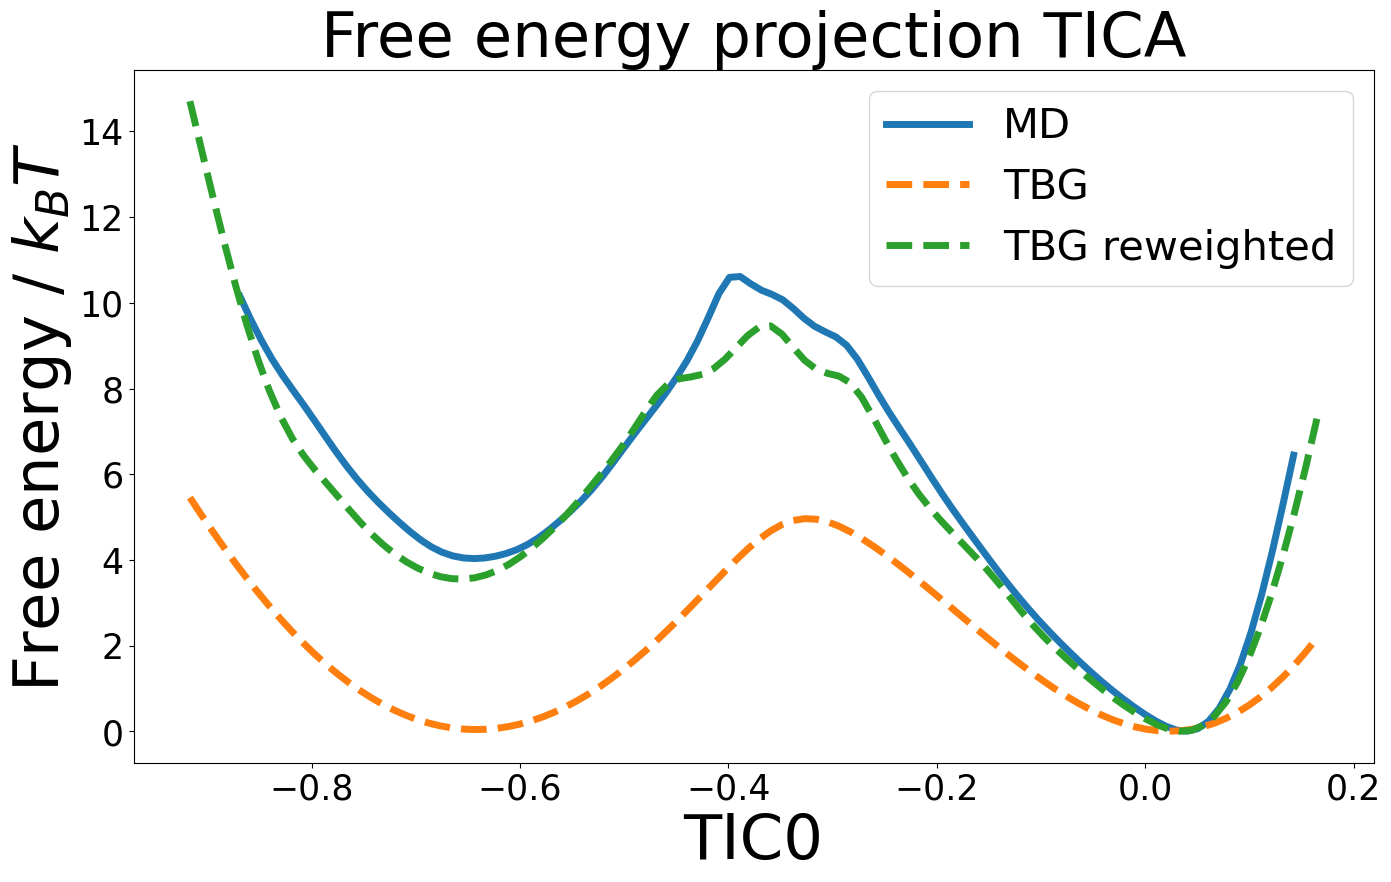

In [18]:
grid_data, fes_data = plot_fes(tics[:,0], bw_method=None, weights=None, get_DeltaF=False)
grid, fes = plot_fes(tics_model[:,0], bw_method=None, weights=None, get_DeltaF=False)
grid_weighted,fes_weighted = plot_fes(tics_model[:,0], bw_method=None, weights=np.exp(pred_md_weights), get_DeltaF=False)
plt.figure(figsize=(16,9))
plt.plot(grid_data, fes_data, linewidth=5, label="MD")
plt.plot(grid, fes, linewidth=5, linestyle="--", label="TBG")
plt.plot(grid_weighted, fes_weighted, linewidth=5, linestyle="--", label="TBG reweighted")
plt.title(r"Free energy projection TICA", fontsize=45)
plt.xlabel("TIC0", fontsize=45)
plt.ylabel("Free energy / $k_B T$", fontsize=45)
plt.legend(fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

In [24]:
calculate_w2_distances(phis_traj, psis_traj, phis_test, psis_test, pred_md_weights, pred_md_energies, classical_target_energies, prefix='Classical MD ')

KeyboardInterrupt: 

In [19]:
data_path = "../data/2AA-1-huge"
#data_path = "data/2AA-1-huge"

atom_dict = {"H": 0, "C":1, "N":2, "O":3, "S":4}
scaling = 30
n_dimensions = 3
data = {}
priors = {}
topologies = {}
atom_types_dict = {}
validation_peptides = ['KS', 'KG', 'AT', 'GN', 'LW', 'KQ', 'NY', 'IM', 'TD', 'HT', 'NF','RL', 'ET', 'AC', 'GP', 'RV']
for peptide in tqdm.tqdm(validation_peptides):   
    npz = np.load(data_path+f"/test/{peptide}-traj-arrays.npz")
    n_atoms = npz['positions'].shape[1]
    data[peptide] = remove_mean(npz['positions'][npz['step']%10000==0].reshape(-1, n_atoms*n_dimensions)[:190000], n_atoms, n_dimensions)*scaling
    topologies[peptide] = md.load_topology(data_path+f"/test/{peptide}-traj-state0.pdb")
    atom_types = []
    for atom_name in topologies[peptide].atoms:
        atom_types.append(atom_name.name[0])
    atom_types_dict[peptide] = np.array([atom_dict[atom_type] for atom_type in atom_types])


    priors[peptide] = MeanFreeNormalDistribution(n_atoms*n_dimensions, n_atoms, two_event_dims=False)#.cuda()

100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


In [23]:
def compute_dipeptide_metrics(test_dipeptide,threshold=0.2):
    pdb_path=f'../data/2AA-1-huge/test/{test_dipeptide}-traj-state0.pdb'
    topology = md.load(pdb_path).topology
    test_md_xyz = np.load(f'../data/2AA-1-huge/test/{test_dipeptide}-traj-arrays.npz')
    test_md=md.Trajectory(test_md_xyz['positions'], topology=topology)
    pred_md = np.load(f'../generated/{test_dipeptide}_ebm_100k_1_{test_dipeptide}_potential_samples_dict.npz')
    pred_md_xyz = pred_md['samples']
    pred_md_energies = pred_md['energies']
    pred_md_weights = pred_md['log_w']
    pred_md_xyz = pred_md_xyz[:pred_md_energies.shape[0]]
    if threshold>0:
        threshold_index=len(pred_md_energies) - int(threshold*len(pred_md_energies)/100)
        pred_md_energies=pred_md_energies[np.argsort(pred_md_weights,axis=0)[:,0],:]
        pred_md_energies=pred_md_energies[:threshold_index,:]
        pred_md_xyz=pred_md_xyz[np.argsort(pred_md_weights,axis=0)[:,0],:]
        pred_md_xyz=pred_md_xyz[:threshold_index,:,:]
        pred_md_weights=np.sort(pred_md_weights,axis=0)[:threshold_index]
    pred_md_weights=torch.from_numpy(pred_md_weights)
    pred_md_weights=pred_md_weights - torch.logsumexp(pred_md_weights, dim=0)
    pred_md_weights=as_numpy(pred_md_weights)
    test_xyz = test_md.xyz[test_md_xyz['step'] % 10000 == 0][:190000]
    pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)
    pdb = openmm.app.PDBFile(pdb_path)
    forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
            nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
    integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
    openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))
    classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(test_xyz)[::10].reshape(-1, test_xyz.shape[-1]*test_xyz.shape[-2])))
    plot_energies(classical_target_energies, pred_md_energies, pred_md_weights,save_path=f'{test_dipeptide}_energy_distribution.pdf')
    phis_traj=md.compute_phi(pred_md_traj)[1].flatten()
    phis_test=md.compute_phi(test_md)[1].flatten()
    fed_traj=compute_free_energy_difference(phis_traj, pred_md_weights, prefix='Trajectory')
    fed_test=compute_free_energy_difference(phis_test, np.zeros((phis_test.shape[0],1)), prefix='Test')
    estimation_error=np.abs(fed_traj-fed_test)
    print("Estimation error:", estimation_error)
    plot_fes_phis(phis_test,phis_traj,pred_md_weights,save_path=f'{test_dipeptide}_fes.pdf')
    psis_traj=md.compute_psi(pred_md_traj)[1].flatten()
    psis_test=md.compute_psi(test_md)[1].flatten()
    tica_model = run_tica(test_md, lagtime=100)
    features = tica_features(test_md)
    tics = tica_model.transform(features)
    pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)
    feat_model = tica_features(pred_md_traj)
    tics_model = tica_model.transform(feat_model)
    grid_data, fes_data = plot_fes(tics[:,0], bw_method=None, weights=None, get_DeltaF=False)
    grid, fes = plot_fes(tics_model[:,0], bw_method=None, weights=None, get_DeltaF=False)
    grid_weighted,fes_weighted = plot_fes(tics_model[:,0], bw_method=None, weights=np.exp(pred_md_weights), get_DeltaF=False)
    plt.figure(figsize=(16,9))
    plt.plot(grid_data, fes_data, linewidth=5, label="MD")
    plt.plot(grid, fes, linewidth=5, linestyle="--", label="Boltzmann Emulator")
    plt.plot(grid_weighted, fes_weighted, linewidth=5, linestyle="--", label="BoltzNCE Reweighted")
    plt.title(r"Free energy projection TICA", fontsize=55)
    plt.xlabel("TIC0", fontsize=55)
    plt.ylabel("Free energy / $k_B T$", fontsize=55)
    plt.legend(fontsize=35)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.savefig(f'{test_dipeptide}_tica_fes.pdf',bbox_inches='tight', dpi=300, format='pdf')
    plt.close()
    energies_w2_proposal_mean,angles_w2_proposal_mean,energies_w2_reweighted_mean,angles_w2_reweighted_mean=calculate_w2_distances(phis_traj, psis_traj, phis_test, psis_test, pred_md_weights, pred_md_energies, classical_target_energies, prefix='Classical MD ')
    return estimation_error, energies_w2_proposal_mean, angles_w2_proposal_mean, energies_w2_reweighted_mean, angles_w2_reweighted_mean


In [24]:
energies_w2_list = []
angles_w2_list = []
energies_w2_reweighted_list = []
angles_w2_reweighted_list = []
estimation_error_list = []
for test_dipeptide in ['AC','ET','GN','IM','KS','NY','NF']:
    print(f"Calculating metrics for {test_dipeptide}")
    estimation_error,energies_w2, angles_w2,energies_w2_reweighted, angles_w2_reweighted = compute_dipeptide_metrics(test_dipeptide)
    energies_w2_list.append(energies_w2)
    angles_w2_list.append(angles_w2)
    energies_w2_reweighted_list.append(energies_w2_reweighted)
    angles_w2_reweighted_list.append(angles_w2_reweighted)
    estimation_error_list.append(estimation_error)
    print("\n" + "="*50 + "\n")
print("Energies W2 mean:", np.mean(energies_w2_list))
print("Energies W2 std:", np.std(energies_w2_list))
print("Angles W2 mean:", np.mean(angles_w2_list))
print("Angles W2 std:", np.std(angles_w2_list))
print("Energies W2 reweighted mean:", np.mean(energies_w2_reweighted_list))
print("Energies W2 reweighted std:", np.std(energies_w2_reweighted_list))
print("Angles W2 reweighted mean:", np.mean(angles_w2_reweighted_list))
print("Angles W2 reweighted std:", np.std(angles_w2_reweighted_list))
print("Estimation error mean:", np.mean(estimation_error_list))
print("Estimation error std:", np.std(estimation_error_list))

Calculating metrics for AC
Trajectory Free energy difference: 4.020842217236087
Test Free energy difference: 3.6647931810937897
Estimation error: 0.3560490361422972
Classical MD Energies W2 distance proposal mean: 5.070002839639367
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.2214827594917863
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.4314774919605655
Classical MD Angles W2 distance reweighted mean: 0.3180195982398632
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for ET
Trajectory Free energy difference: 3.890764232233848
Test Free energy difference: 4.113020701645649
Estimation error: 0.22225646941180077
Classical MD Energies W2 distance proposal mean: 11.142879409705115
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.8863073107535391
Cla

In [26]:
import networkx.algorithms.isomorphism as iso
import networkx as nx
import scipy

def align_topology(sample, reference, scaling,atom_types):
    sample = sample.reshape(-1, 3)
    all_dists = scipy.spatial.distance.cdist(sample, sample)
    adj_list_computed = create_adjacency_list(all_dists/scaling, atom_types)
    G_reference = nx.Graph(reference)
    G_sample = nx.Graph(adj_list_computed)
    # not same number of nodes
    if len(G_sample.nodes) != len(G_reference.nodes):
        return sample, False
    for i, atom_type in enumerate(atom_types):
        G_reference.nodes[i]['type']=atom_type
        G_sample.nodes[i]['type']=atom_type
        
    nm = iso.categorical_node_match("type", -1)
    GM = isomorphism.GraphMatcher(G_reference, G_sample, node_match=nm)
    is_isomorphic = GM.is_isomorphic()
    # True
    GM.mapping
    initial_idx = list(GM.mapping.keys())
    final_idx = list(GM.mapping.values())
    sample[initial_idx] = sample[final_idx]
    return sample, is_isomorphic

In [27]:
import signal


In [28]:
def compute_tbg_dipeptide_metric(test_dipeptide):
   loaded_samples = np.load(f"../generated/tbg_full_biased_{test_dipeptide}.npz")
   dim =len(atom_types_dict[test_dipeptide])*n_dimensions
   latent_np = loaded_samples["latent_np"]
   samples_np = loaded_samples["samples_np"]
   dlogp_np=loaded_samples["dlogp_np"] 

   test_md_xyz = np.load(f'../data/2AA-1-huge/test/{test_dipeptide}-traj-arrays.npz')
   topology=topologies[test_dipeptide]
   test_md=md.Trajectory(test_md_xyz['positions'], topology=topology)
   test_xyz = test_md.xyz[test_md_xyz['step'] % 10000 == 0][:190000]
   
   atom_dict = {"C": 0, "H":1, "N":2, "O":3, "S":4}
   #["C", "H", "N", "O", "S"]
   atom_types = []
   for atom_name in topologies[test_dipeptide].atoms:
      atom_types.append(atom_name.name[0])
   atom_types = torch.from_numpy(np.array([atom_dict[atom_type] for atom_type in atom_types]))
   backbone_idxs = topologies[test_dipeptide].select("backbone")
   adj_list = torch.from_numpy(np.array([(b.atom1.index, b.atom2.index) for b in topologies[test_dipeptide].bonds], dtype=np.int32))
   def handler(signum, frame):
    raise TimeoutError("Function call took too long")

   aligned_samples = []
   aligned_idxs = []
   #for i, sample in enumerate(samples_np[(energies_np.flatten() < -52800)].reshape(-1,dim//3, 3)):
   for i, sample in tqdm.tqdm(enumerate(samples_np.reshape(-1,dim//3, 3))):   
         # Set a timer for 5 seconds
      signal.signal(signal.SIGALRM, handler)
      signal.alarm(5)  # Timeout set to 5 seconds

      try:
         # Call your function here
         aligned_sample, is_isomorphic = align_topology(sample, as_numpy(adj_list).tolist(),scaling=scaling,atom_types=atom_types)
         if is_isomorphic:
               aligned_samples.append(aligned_sample)
               aligned_idxs.append(i)
      except TimeoutError: 
         print("Skipping iteration, function call took too long")
         continue  # Skip to the next iteration
      finally:
         signal.alarm(0)

   aligned_samples = np.array(aligned_samples)
   traj_samples_alinged = md.Trajectory(aligned_samples/scaling, topology=topologies[test_dipeptide])
   model_samples = torch.from_numpy(traj_samples_alinged.xyz)
   chirality_centers = find_chirality_centers(adj_list, atom_types)
   reference_signs = compute_chirality_sign(torch.from_numpy(data[test_dipeptide].reshape(-1, dim//3, 3))[[1]], chirality_centers)
   symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)
   model_samples[symmetry_change] *=-1
   symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)
   pdb_path = data_path+f"/test/{test_dipeptide}-traj-state0.pdb"

   pdb = openmm.app.PDBFile(pdb_path)
   forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")

   system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
         nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
   integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
   openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))
   classical_model_energies = as_numpy(openmm_energy.energy(model_samples.reshape(-1, dim)[~symmetry_change]))
   classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(test_xyz)[::10].reshape(-1, test_xyz.shape[-1]*test_xyz.shape[-2])))
   idxs = np.array(aligned_idxs)[~symmetry_change]
   log_w_np = -classical_model_energies + as_numpy(priors[test_dipeptide].energy(torch.from_numpy(latent_np[idxs]))) + dlogp_np.reshape(-1,1)[idxs]
   traj_samples=md.Trajectory(model_samples[~symmetry_change].numpy(), topology=topologies[test_dipeptide])
   phis_traj=md.compute_phi(traj_samples)[1].flatten()
   phis_test=md.compute_phi(test_md)[1].flatten()
   print(log_w_np.shape)
   fed_traj=compute_free_energy_difference(phis_traj, log_w_np, prefix='Trajectory')
   fed_test=compute_free_energy_difference(phis_test, np.zeros((phis_test.shape[0],1)), prefix='Test')
   estimation_error=np.abs(fed_traj-fed_test)
   print("Estimation error:", estimation_error)
   psis_traj=md.compute_psi(traj_samples)[1].flatten()
   psis_test=md.compute_psi(test_md)[1].flatten()
   energies_w2_proposal_mean,angles_w2_proposal_mean,energies_w2_reweighted_mean,angles_w2_reweighted_mean=calculate_w2_distances(phis_traj, psis_traj, phis_test, psis_test, log_w_np, classical_model_energies, classical_target_energies, prefix='Classical MD ')
   return estimation_error, energies_w2_proposal_mean, angles_w2_proposal_mean, energies_w2_reweighted_mean, angles_w2_reweighted_mean



In [29]:
energies_w2_list = []
angles_w2_list = []
energies_w2_reweighted_list = []
angles_w2_reweighted_list = []
estimation_error_list = []
for test_dipeptide in ['AC','ET','GN','IM','KS','NY','NF']:
    print(f"Calculating metrics for {test_dipeptide}")
    estimation_error,energies_w2, angles_w2,energies_w2_reweighted, angles_w2_reweighted = compute_tbg_dipeptide_metric(test_dipeptide)
    energies_w2_list.append(energies_w2)
    angles_w2_list.append(angles_w2)
    energies_w2_reweighted_list.append(energies_w2_reweighted)
    angles_w2_reweighted_list.append(angles_w2_reweighted)
    estimation_error_list.append(estimation_error)
    print("\n" + "="*50 + "\n")
print("Energies W2 mean:", np.mean(energies_w2_list))
print("Energies W2 std:", np.std(energies_w2_list))
print("Angles W2 mean:", np.mean(angles_w2_list))
print("Angles W2 std:", np.std(angles_w2_list))
print("Energies W2 reweighted mean:", np.mean(energies_w2_reweighted_list))
print("Energies W2 reweighted std:", np.std(energies_w2_reweighted_list))
print("Angles W2 reweighted mean:", np.mean(angles_w2_reweighted_list))
print("Angles W2 reweighted std:", np.std(angles_w2_reweighted_list))
print("Estimation error mean:", np.mean(estimation_error_list))
print("Estimation error std:", np.std(estimation_error_list))

Calculating metrics for AC


30000it [01:20, 374.96it/s]


(28069, 1)
Trajectory Free energy difference: 3.5748165047374054
Test Free energy difference: 3.6647931810937897
Estimation error: 0.08997667635638429
Classical MD Energies W2 distance proposal mean: 3.745450404907074
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.167559380993367
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.20253062388610094
Classical MD Angles W2 distance reweighted mean: 0.29053453265848067
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for ET


30000it [02:26, 204.66it/s]


(28482, 1)
Trajectory Free energy difference: 4.300037144873797
Test Free energy difference: 4.113020701645649
Estimation error: 0.18701644322814825
Classical MD Energies W2 distance proposal mean: 8.207429928594845
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.8556420926950415
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.4923406043262766
Classical MD Angles W2 distance reweighted mean: 0.34116116483430103
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for GN


30000it [01:25, 350.12it/s]


(29993, 1)
Trajectory Free energy difference: 4.205197380873404
Test Free energy difference: 4.560364887977715
Estimation error: 0.3551675071043112
Classical MD Energies W2 distance proposal mean: 6.193464929446249
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.9594014100988056
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.19854044058822382
Classical MD Angles W2 distance reweighted mean: 0.26680569130333676
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for IM


30000it [03:10, 157.78it/s]


(28195, 1)
Trajectory Free energy difference: 3.701876888952916
Test Free energy difference: 3.7278463224322214
Estimation error: 0.02596943347930525
Classical MD Energies W2 distance proposal mean: 10.741096869516214
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.689485169398727
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.4304945532126062
Classical MD Angles W2 distance reweighted mean: 0.36194587136306255
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for KS


30000it [02:47, 179.53it/s]


(29554, 1)
Trajectory Free energy difference: 3.2144667237643954
Test Free energy difference: 3.0814247860593222
Estimation error: 0.1330419377050731
Classical MD Energies W2 distance proposal mean: 8.500093325745315
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.9439062552810719
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.47362818534077294
Classical MD Angles W2 distance reweighted mean: 0.4345313518621715
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for NY


30000it [03:25, 146.09it/s]


(29662, 1)
Trajectory Free energy difference: 3.3939235004715513
Test Free energy difference: 3.35966793746639
Estimation error: 0.03425556300516153
Classical MD Energies W2 distance proposal mean: 6.401539008174142
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.0933854007821282
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.49072661347321994
Classical MD Angles W2 distance reweighted mean: 0.4246518171547029
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for NF


30000it [03:13, 155.07it/s]


(29655, 1)
Trajectory Free energy difference: 3.468265773877985
Test Free energy difference: 3.570180694202293
Estimation error: 0.10191492032430816
Classical MD Energies W2 distance proposal mean: 7.198060959544686
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.0568127761172232
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.27502886186778186
Classical MD Angles W2 distance reweighted mean: 0.30150305839208585
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Energies W2 mean: 7.28387648941836
Energies W2 std: 2.0276604169827417
Angles W2 mean: 0.9665989264809092
Angles W2 std: 0.1484532961218216
Energies W2 reweighted mean: 0.36618426895642603
Energies W2 reweighted std: 0.1255288818997757
Angles W2 reweighted mean: 0.34587621250973444
Angles W2 reweighted std: 0.0605092919546636
Estimation error mean: 0.132477497314670